In [1]:
import matplotlib.pyplot as plt
import PIL

In [2]:
import torch, torchvision
import numpy as np
rng = np.random.default_rng()
import time
from tqdm.notebook import tqdm   ### suitable for notebooks

In [3]:
fname = 'EMNIST_torch'

### Download and initialize datasets
TrainDS_orig = torchvision.datasets.EMNIST(fname, train=True, download=True, split='letters', transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img)
                ]))
TestDS_orig = torchvision.datasets.EMNIST(fname, train=False, split='letters', transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img)
                ]))

A - 1

B - 2

.
.
.
.

In [27]:
# Size of dataset
print(len(TrainDS_orig)) #124800
# Details of dataset
print(TrainDS_orig)
## Show the pixel values of an image from training data
# print(np.asarray(TrainDS_orig[0][0].getdata()))

## Calculate mean alternative 1
tot = 0.0
for inputs,labels in TrainDS_orig:
    tot = tot + np.asarray(inputs.getdata())/255

mean = tot.mean()/len(TrainDS_orig) 
print(tot.mean()/len(TrainDS_orig))

## Calculate mean alternative 2
tot = 0.0
for inputs,labels in TrainDS_orig:
    tot = tot + np.asarray(inputs.getdata()).mean()/255

print(tot/124800)

## Calculate standard deviation
tot = 0.0
for inputs,labels in TrainDS_orig:
    tot = tot + (np.asarray(inputs.getdata()).mean()/255 - mean)**2
std = np.sqrt(tot/len(TrainDS_orig))
print(np.sqrt(tot/len(TrainDS_orig)))

124800
Dataset EMNIST
    Number of datapoints: 124800
    Root location: EMNIST_torch
    Split: Train
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x00000211CF4B59D8>
               <function <lambda> at 0x00000211CF4B5C18>
           )
0.1722273037019352
0.17222730370193096
0.05212017405682751


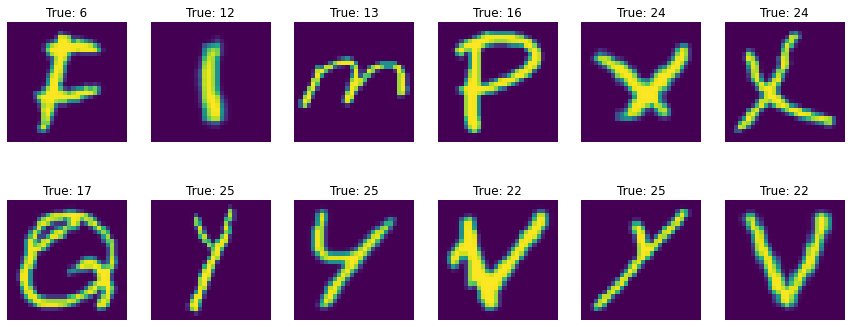

In [4]:
### Plot examples
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS_orig))
        image, orig_label = TestDS_orig[test_index]
        ax.set_axis_off()
        ax.imshow(image)
#         ax.imshow(PIL.ImageOps.mirror(image.rotate(-90)))
        ax.set_title('True: %i' % orig_label)

In [31]:
### Define the label transform from an integer to a set of probabilities
def target_transform(inlabel):
    newlabel = torch.zeros(27)
    newlabel[inlabel] = 1.
    return newlabel

def input_transform(image):
    image = torchvision.transforms.functional.rotate(image,-90)
    image = torchvision.transforms.functional.hflip(image)
    tensor = torchvision.transforms.functional.to_tensor(image)
    return tensor

### Reinitialize datasets with the transforms
TrainDS = torchvision.datasets.EMNIST(fname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1722273), (0.0521201))
                ]), split='letters')
TestDS = torchvision.datasets.EMNIST(fname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1722273), (0.0521201))
                ]), split='letters')

### Initialize DataLoaders as PyTorch convenience
TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=200)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=200)

### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

### Define the dense neuron layer
# Network = torch.nn.Sequential(
#     torch.nn.Flatten(),            # 28x28 -> 784
#     torch.nn.Linear(784, 10),      # 784 -> 10
#     torch.nn.Softmax(dim=1)
# )
Network = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 400),
    torch.nn.ReLU(),
    torch.nn.Linear(400, 27),
    torch.nn.Softmax(dim=1)
)
Network.to(device=device)

### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
crit = torch.nn.BCELoss()
opt = torch.optim.SGD(Network.parameters(), lr=0.6)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=400, bias=True)
  (2): ReLU()
  (3): Linear(in_features=400, out_features=27, bias=True)
  (4): Softmax(dim=1)
)
324827 trainable parameters


In [32]:
### Baseline: just say it's anything at probability 1/N, what's the loss?
N = 27
labels = torch.zeros(1, 27, dtype=torch.float32)
labels[0, 3] = 1.
output = torch.full_like(labels, 1./N)
print(crit(output, labels))

tensor(0.1584)


In [33]:
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, 40)

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for inputs, labels in tqdm(TrainDL, leave=False):
        opt.zero_grad() # zero gradient values
        inputs = inputs.to(device=device) # move input and label tensors to the device with the model
        labels = labels.to(device=device)
        outputs = Network(inputs) # compute model outputs
        loss = crit(outputs, labels) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputs) # add the batch loss to the running loss
        samples += len(inputs) # update the number of processed samples
    tr_loss /= samples # compute training loss
    print(e, tr_loss)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

1 0.040930635182378


  0%|          | 0/624 [00:00<?, ?it/s]

2 0.023987859590516355


  0%|          | 0/624 [00:00<?, ?it/s]

3 0.019709537322155368


  0%|          | 0/624 [00:00<?, ?it/s]

4 0.01737100326975521


  0%|          | 0/624 [00:00<?, ?it/s]

5 0.015630830186031137


  0%|          | 0/624 [00:00<?, ?it/s]

6 0.014411276351147069


  0%|          | 0/624 [00:00<?, ?it/s]

7 0.01339851027333703


  0%|          | 0/624 [00:00<?, ?it/s]

8 0.012461036403412716


  0%|          | 0/624 [00:00<?, ?it/s]

9 0.011590910875477279


  0%|          | 0/624 [00:00<?, ?it/s]

10 0.010944175609321788


  0%|          | 0/624 [00:00<?, ?it/s]

11 0.010264856143084426


  0%|          | 0/624 [00:00<?, ?it/s]

12 0.00977358526777094


  0%|          | 0/624 [00:00<?, ?it/s]

13 0.009136032520566518


  0%|          | 0/624 [00:00<?, ?it/s]

14 0.008639339356495138


  0%|          | 0/624 [00:00<?, ?it/s]

15 0.008248358510079412


  0%|          | 0/624 [00:00<?, ?it/s]

16 0.007882979033941714


  0%|          | 0/624 [00:00<?, ?it/s]

17 0.0074631543009159845


  0%|          | 0/624 [00:00<?, ?it/s]

18 0.0070677273686623006


  0%|          | 0/624 [00:00<?, ?it/s]

19 0.006759656910360672


  0%|          | 0/624 [00:00<?, ?it/s]

20 0.006458717028577574


  0%|          | 0/624 [00:00<?, ?it/s]

21 0.006060323038045914


  0%|          | 0/624 [00:00<?, ?it/s]

22 0.005911196631645091


  0%|          | 0/624 [00:00<?, ?it/s]

23 0.005618140524184594


  0%|          | 0/624 [00:00<?, ?it/s]

24 0.0053453008433093484


  0%|          | 0/624 [00:00<?, ?it/s]

25 0.005101256587994822


  0%|          | 0/624 [00:00<?, ?it/s]

26 0.00500883531472377


  0%|          | 0/624 [00:00<?, ?it/s]

27 0.0047312300786217796


  0%|          | 0/624 [00:00<?, ?it/s]

28 0.004574867517826183


  0%|          | 0/624 [00:00<?, ?it/s]

29 0.004385325122991792


  0%|          | 0/624 [00:00<?, ?it/s]

30 0.0042190585219755005


  0%|          | 0/624 [00:00<?, ?it/s]

31 0.003997592421047813


  0%|          | 0/624 [00:00<?, ?it/s]

32 0.0038561337858435507


  0%|          | 0/624 [00:00<?, ?it/s]

33 0.0037405132209711997


  0%|          | 0/624 [00:00<?, ?it/s]

34 0.0036162184913290474


  0%|          | 0/624 [00:00<?, ?it/s]

35 0.0035368318884791685


  0%|          | 0/624 [00:00<?, ?it/s]

36 0.0034371551968760262


  0%|          | 0/624 [00:00<?, ?it/s]

37 0.0032954714009601725


  0%|          | 0/624 [00:00<?, ?it/s]

38 0.0032344741099596154


  0%|          | 0/624 [00:00<?, ?it/s]

39 0.0031310178281460255


In [34]:
### Set model in evaluation mode
Network.eval()

### Compute the test loss
with torch.no_grad():
    te_loss = 0.
    samples = 0
    accuracy = 0
    ### Loop over batches
    for inputs, labels in tqdm(TestDL):
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = Network(inputs)
        loss = crit(outputs, labels)
        te_loss += loss.clone().cpu().item()*len(inputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs)
    te_loss /= samples
    accuracy /= samples
    print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))

  0%|          | 0/104 [00:00<?, ?it/s]

Test loss: 0.029237, accuracy: 0.899663


In [9]:
torch.save(Network, 'model_torch_EMNIST_letters.chk')

In [58]:
Network = torch.load('model_torch_EMNIST_letters_0.chk')
device='cpu'

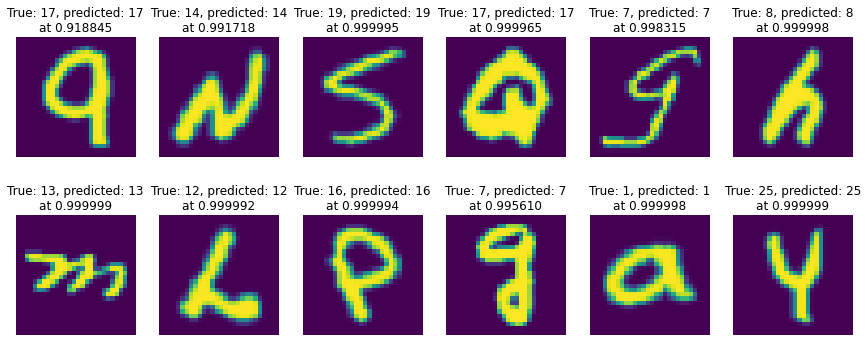

In [64]:
### Draw some random images from the test dataset and compare the true labels to the network outputs
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
### Loop over subplots
for axes_row in axes:
    for ax in axes_row:
        ### Draw the images
        test_index = rng.integers(0, len(TestDS))
        sample, label = TestDS[test_index]
        image, orig_label = TestDS_orig[test_index]
        ### Compute the predictions
        with torch.no_grad():
            output = Network(torch.unsqueeze(sample, dim=0).to(device=device))
            certainty, output = torch.max(output[0], 0)
            certainty = certainty.clone().cpu().item()
            output = output.clone().cpu().item()
        ### Show image
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i, predicted: %i\nat %f' % (orig_label, output, certainty))

(144, 45)
(154, 55)
5 5

tensor([[6.7429e-14, 1.6134e-15, 1.5796e-06, 2.5935e-06, 1.8214e-08, 7.8746e-13,
         8.1922e-18, 2.5841e-20, 8.6262e-03, 1.5274e-02, 2.3790e-10, 2.6852e-05,
         9.7597e-01, 2.5335e-11, 3.0370e-05, 1.5570e-16, 5.2469e-15, 4.4369e-17,
         9.6452e-10, 6.1919e-16, 5.0926e-06, 2.0706e-06, 6.1295e-05, 1.0589e-09,
         1.0351e-08, 9.3907e-20, 1.1225e-10]])
12
L
tensor([0.9760, 0.0153, 0.0086])
tensor([12,  9,  8])
L
I
H


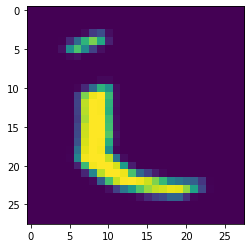

In [73]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
import cv2

width = 200  # canvas width
height = 200 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    filename = "user_input.png"
    global output_image 
    output_image.save(filename)
    ###### Centering begin
    # Load image as grayscale and obtain bounding box coordinates
    image = cv2.imread('user_input.png', 0)
    height, width = image.shape
    x,y,w,h = cv2.boundingRect(image)


    # Create new blank image and shift ROI to new coordinates
    ROI = image[y:y+h, x:x+w]
    mask = np.zeros([ROI.shape[0]+10,ROI.shape[1]+10])
    width, height = mask.shape
    print(ROI.shape)
    print(mask.shape)
    x = width//2 - ROI.shape[0]//2 
    y = height//2 - ROI.shape[1]//2 
    print(x,y)
    mask[y:y+h, x:x+w] = ROI

    # Check if centering/masking was successful
#     plt.imshow(mask, cmap='viridis') 
    output_image = PIL.Image.fromarray(mask) # mask has values in [0-255] as expected
    # Now we need to resize, but it causes problems with default arguments as it changes the range of pixel values to be negative or positive
    # compressed_output_image = output_image.resize((22,22))
    # Therefore, we use the following:
    compressed_output_image = output_image.resize((22,22), PIL.Image.BILINEAR) # PIL.Image.NEAREST or PIL.Image.BILINEAR also performs good
#     # Enhance Saturation
#     converter = PIL.ImageEnhance.Color(compressed_output_image)
#     compressed_output_image = converter.enhance(2.5)
    # Enhance contrast
#     converter = PIL.ImageEnhance.Contrast(compressed_output_image)
#     compressed_output_image = converter.enhance(3.5)
    convert_tensor = torchvision.transforms.ToTensor()
    tensor_image = convert_tensor(compressed_output_image)
    # Another problem we face is that in the above ToTensor() command, we should have gotten a normalized tensor with pixel values in [0,1]
    # But somehow it doesn't happen. Therefore, we need to normalize manually
    tensor_image = tensor_image/255.
    # Padding
    tensor_image = torch.nn.functional.pad(tensor_image, (3,3,3,3), "constant", 0)
    # Normalization shoudl be done after padding i guess
    convert_tensor = torchvision.transforms.Normalize((0.1722273), (0.0521201))
    tensor_image = convert_tensor(tensor_image)
    plt.imshow(tensor_image.detach().cpu().numpy().reshape(28,28), cmap='viridis')
    # Debugging
#     print(tensor_image)
#     print(np.array(compressed_output_image.getdata())) # Get data values)
#     print(np.array(image.getdata()))

    ### Compute the predictions
    print()
    with torch.no_grad():
#         print(tensor_image)
        output0 = Network(torch.unsqueeze(tensor_image, dim=0).to(device=device))
        print(output0)
        certainty, output = torch.max(output0[0], 0)
        certainty = certainty.clone().cpu().item()
        output = output.clone().cpu().item()
        certainty1, output1 = torch.topk(output0[0],3)
        certainty1 = certainty1.clone().cpu()#.item()
        output1 = output1.clone().cpu()#.item()
#     print(certainty)
    print(output)
    print(chr(ord('@')+output))
    print(certainty1)
    print(output1)
    for i in output1:
        print(chr(ord('@')+i))

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
#     canvas.create_oval(x1, y1, x2, y2, fill="white",width=24)
    canvas.create_rectangle(x1, y1, x2, y2, fill="white",width=12)
    draw.line([x1, y1, x2, y2],fill="white",width=12)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("L", (width, height), 0)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="save",command=save)
button.pack()

master.mainloop()

In [13]:
# Debugging
# plt.imshow(image, cmap='viridis')

# References:
https://stackoverflow.com/questions/59535286/improve-real-life-results-of-neural-network-trained-with-mnist-dataset